## Setup the environment

### Clone repository

In [1]:
%env EXERCISE_NAME=04-ape-and-fine-tuning
%env REPO_NAME=llmops-workshop

env: EXERCISE_NAME=04-ape-and-fine-tuning
env: REPO_NAME=llmops-workshop


In [2]:
! echo "Cloning the repository...${REPO_NAME}"

Cloning the repository...llmops-workshop


In [ ]:
! git clone https://github.com/getindata/$REPO_NAME.git

## Tools versions

In [74]:
%env LLAMA_CPP_VERSION=b5043

env: LLAMA_CPP_VERSION=b5043


In [3]:
def is_colab():
    try:
        import google.colab  # noqa: F401

        return True
    except ImportError:
        return False

### Prepare environment variables, Python modules search path and install dependencies

In [4]:
import os
if is_colab():
    os.environ["EXERCISE_ROOT"] = f"/content/${os.environ['REPO_NAME']}/exercises"
    os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia"
    os.environ["EXERCISE_RUN"] = "colab"
else:
    os.environ["EXERCISE_ROOT"] = f"{os.getcwd()}/exercises"
    os.environ["EXERCISE_RUN"] = "local"

os.environ['EXERCISE_DIR'] = f"{os.environ['EXERCISE_ROOT']}/{os.environ['EXERCISE_NAME']}"
get_ipython().run_line_magic("run", f"{os.environ['EXERCISE_ROOT']}/shared/setup/__setup_{os.environ['EXERCISE_RUN']}.ipynb")

/Users/mwiewior/research/git/llmops-workshop/exercises/04-ape-and-fine-tuning


In [5]:
import sys

sys.path.append(f"{os.environ['EXERCISE_DIR']}/src")

In [94]:
%pip install -r {os.environ['EXERCISE_DIR']}/requirements.txt

  Cloning https://github.com/mwiewior/mlflow.git (to revision dspy-bug) to /private/var/folders/l3/8404fxz55gvdfszw4zf7ptp40000gn/T/pip-req-build-r7vqr3v7
  Running command git clone --filter=blob:none --quiet https://github.com/mwiewior/mlflow.git /private/var/folders/l3/8404fxz55gvdfszw4zf7ptp40000gn/T/pip-req-build-r7vqr3v7
  Running command git checkout -b dspy-bug --track origin/dspy-bug
  Switched to a new branch 'dspy-bug'
  branch 'dspy-bug' set up to track 'origin/dspy-bug'.
  Resolved https://github.com/mwiewior/mlflow.git to commit 2322a6fe88c5c2eb39b64232a87c0c34c46d53e6
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached mlx_lm-0.22.2-py3-none-any.whl.metadata (10 kB)
  Using cached mlx-0.24.2-cp311-cp311-macosx_15_0_arm64.whl.metadata (5.3 kB)
  Using cached transformers-4.50.3-py3-none-any.whl.metadata (39 kB)
  Us

## Test the environment

In [90]:
!llama-cli --version

version: 5002 (2c3f8b85)
built with Apple clang version 16.0.0 (clang-1600.0.26.6) for arm64-apple-darwin24.2.0


In [91]:
!ollama --version

ollama version is 0.6.3


In [93]:
%%bash
ollama pull gemma3:1b > /dev/null 2>&1
curl -sX POST http://localhost:11434/api/generate -d '{
"model": "gemma3:1b",
"system": "Be helpful and concise.",
"prompt":"Who discovered general theory of relativity?.Just answer with the name of the scientist."
}' | jq -r '. | {response} | join(",")' | tr -d '\n'

Albert Einstein

### Langfuse connection (also OpenTelemetry)

In [6]:
import base64
import os

os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-005b77e6-7931-475e-85bd-46ec47e5201d"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-8b31ee9a-2c89-4c47-a37a-ec084d735170"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"
os.environ["LANGFUSE_AUTH"] = base64.b64encode(
    f"{os.environ['LANGFUSE_PUBLIC_KEY']}:{os.environ['LANGFUSE_SECRET_KEY']}".encode()
).decode()
os.environ["OTEL_EXPORTER_OTLP_TRACES_ENDPOINT"] = (
    f"{os.environ['LANGFUSE_HOST']}/api/public/otel/v1/traces"
)
os.environ["OTEL_EXPORTER_OTLP_TRACES_HEADERS"] = (
    f"Authorization=Basic {os.environ['LANGFUSE_AUTH']}"
)
os.environ["OTEL_EXPORTER_OTLP_TRACES_PROTOCOL"] = "http/protobuf"

In [7]:
from langfuse import Langfuse

langfuse = Langfuse()

## Data preparation

In [8]:
import polars as pl

df = pl.read_csv(f"{os.environ['EXERCISE_DIR']}/data/input/sms_phishing.csv")
datasets = []
for r in df.iter_rows(named=True):
    datasets.append({"input": r["TEXT"], "expected_output": r["LABEL"].lower()})

In [ ]:
TRAIN_PCT = 0.9666
VAL_PCT = 0.0167
TEST_PCT = 0.0167
train_ds = datasets[: int(len(datasets) * TRAIN_PCT)]
val_ds = datasets[
    int(len(datasets) * TRAIN_PCT) : int(len(datasets) * (TRAIN_PCT + VAL_PCT))
]
test_ds = datasets[int(len(datasets) * (TRAIN_PCT + VAL_PCT)) :]
len(train_ds), len(val_ds), len(test_ds)

### Create Langfuse datasets


In [ ]:
def create_dataset(name: str, ds: list):
    langfuse.create_dataset(name=name)
    for item in ds:
        langfuse.create_dataset_item(
            dataset_name=name,
            input=item["input"],
            expected_output=item["expected_output"],
        )

In [ ]:
create_dataset("sms_phishing_train", train_ds)
create_dataset("sms_phishing_val", val_ds)
create_dataset("sms_phishing_test", test_ds)

## Register the prompt

In [ ]:
langfuse.create_prompt(
    name="sms-classifier",
    type="text",
    prompt=" Given an SMS text, classify whether it is 'ham', 'spam', or 'smishing'. Output only the predicted category.",
    labels=["sandbox"],
    tags=["sms", "dspy", "classifier"],
)

## Create a SMSClassifier module with DSPy

### Configure which LLM to use (Ollama Gemma3)
DSpy uses [LiteLLM](https://www.litellm.ai/) to abstract the LLM provider.

In [9]:
import dspy

MODEL = "gemma3:1b"

lm = dspy.LM(f"ollama/{MODEL}", cache=False, num_retries=5)
dspy.settings.configure(lm=lm, track_usage=False)

### Configuring DSPy traces with OpenTelemetry using MLflow client

In [11]:
import mlflow

mlflow.dspy.autolog()

In [ ]:
import logging

logger = logging.getLogger("mlflow")
logger.setLevel(logging.INFO)

In [ ]:
lm("Hello world!")

### Create a DSPy
1. We first create a Signature that defines the schema of the input and output of the module and well as the default instructions.
2. Then we create a Module that combines the Signature with the prompting strategy, such Chain of Thought, ReAct, .


In [12]:
from typing import Literal

import dspy


class SMSClassifierSignature(dspy.Signature):
    """
    Given an SMS text, predict whether it is ham, spam, or smishing.
    Output only the predicted label.
    """

    sms_text: str = dspy.InputField()
    category: Literal["ham", "spam", "smishing"] = dspy.OutputField()


class SMSClassifier(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_answer = dspy.Predict(SMSClassifierSignature)

    @mlflow.trace
    def forward(self, sms_text):
        return self.generate_answer(sms_text=sms_text)

In [15]:
sms_classifier = SMSClassifier()

### Change the default instructions

In [ ]:
SMSClassifierSignature.__doc__ = langfuse.get_prompt(
    name="sms-classifier", version=2
).compile()
sms_classifier = SMSClassifier()

In [ ]:
sms_classifier(sms_text="Sorry i missed your call. Can you please call back.")

In [ ]:
sms_classifier(
    sms_text="We have received a request from you for purchasing Paytm Payments Bank FASTag. Total amount to be paid is Rs 250/- (Tag Cost Rs. 100 Security Deposit Rs. 0, Threshold -Rs. 150). In case of any queries, please contact us at https://m.paytm.me/fastag-help"
)

In [ ]:
# wrong should be categorized as spam
sms_classifier(
    sms_text="Rental  Helpline  9999991155 1000-100, 000 sq.ft. In Noida & Gr.Noida  OFFICE & INDUSTRIAL Use Goldenberg estates pvt.ltd. sandeep@goldenberg.in 999 999 115"
)

In [ ]:
lm.inspect_history(n=1)

## Run evaluation on the test dataset

### Pull the models

In [ ]:
%%bash
models=("gemma3:1b" "qwen2.5:1.5b" "qwen2.5:14b" "gemma3:12b")
for model in "${models[@]}"; do
    echo "Pulling model: $model"
    ollama pull "$model"
done


### Prepare the test dataset

In [16]:
dataset = langfuse.get_dataset("sms_phishing_test")
from dspy import Example

test_ds = []
for item in dataset.items:
    test_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [36]:
import uuid
from evaluation_helpers import plot_metrics, run_evaluation

baseline_run_id = "uuid.uuid1()"

models = [
    "gemma3:1b",
    "qwen2.5:1.5b",
    "qwen2.5:14b",
    "gemma3:12b",
]


# full run (if you would like to run all models - remember to pull them first)
# models = [
#         "smollm2:360m", "smollm2:1.7b",
#         "qwen2.5:0.5b", "qwen2.5:1.5b",
#         "gemma3:1b", "gemma3:4b", "granite3.2:2b",
#         "gemma3:12b", "qwen2.5:14b", "phi4:14b"
# ]

classes = ["ham", "spam", "smishing"]

run_evaluation(
    models, sms_classifier, test_ds, classes, baseline_run_id, prefix="baseline"
)

Average Metric: 78.00 / 100 (78.0%): 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [37]:
from evaluation_helpers import get_all_metric

metrics_baseline = get_all_metric(models, baseline_run_id, classes, prefix="baseline")

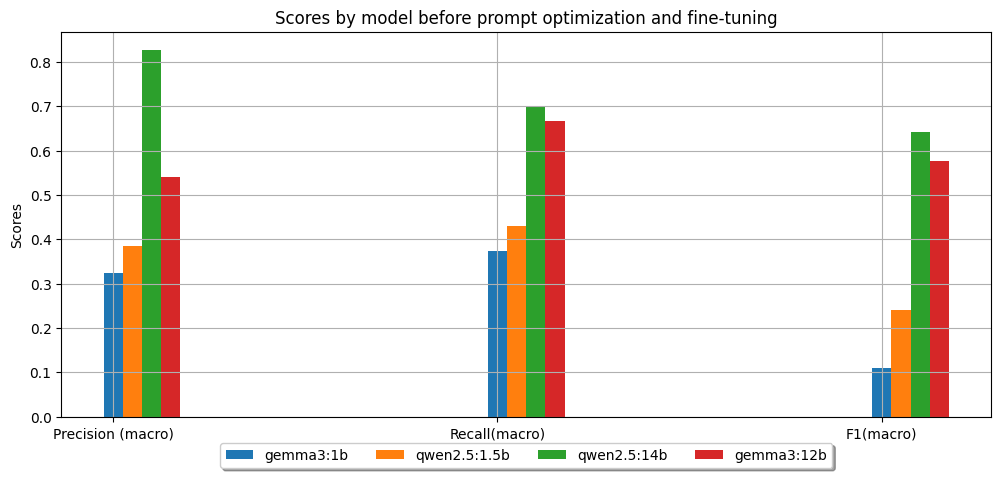

In [38]:
plot_metrics(
    metrics_baseline,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before prompt optimization and fine-tuning",
)

## Automatic prompt engineering

### Prepare the training dataset

In [25]:
from collections import Counter
from dspy import Example

dataset = langfuse.get_dataset("sms_phishing_train")

sample_size = 100
category_split = {"ham": 0.6, "spam": 0.2, "smishing": 0.2}
sample_counts = {"ham": 0, "spam": 0, "smishing": 0}
ham_num = sample_size * category_split["ham"]
spam_num = sample_size * category_split["spam"]
smishing_num = sample_size * category_split["smishing"]
train_ds = []
for item in dataset.items:
    train_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )


categories = [item.category for item in train_ds[:sample_size]]
Counter(categories)

Counter({'ham': 84, 'spam': 9, 'smishing': 7})

In [26]:
lm = dspy.LM(f"ollama/{MODEL}", cache=False)
dspy.settings.configure(lm=lm, track_usage=False)

In [27]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from evaluation_helpers import validate_answer

config = dict(
    max_bootstrapped_demos=2,
    max_labeled_demos=8,
    num_candidate_programs=4,
    num_threads=1,
    max_errors=10,
)

teleprompter = BootstrapFewShotWithRandomSearch(metric=validate_answer, **config)
optimized_program = teleprompter.compile(
    sms_classifier, trainset=train_ds[:sample_size]
)

Going to sample between 1 and 2 traces per predictor.
Will attempt to bootstrap 4 candidate sets.
Average Metric: 69.00 / 100 (69.0%): 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]

2025/04/03 18:10:17 INFO dspy.evaluate.evaluate: Average Metric: 69 / 100 (69.0%)



New best score: 69.0 for seed -3
Scores so far: [69.0]
Best score so far: 69.0
Average Metric: 85.00 / 100 (85.0%): 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]

2025/04/03 18:10:32 INFO dspy.evaluate.evaluate: Average Metric: 85 / 100 (85.0%)



New best score: 85.0 for seed -2
Scores so far: [69.0, 85.0]
Best score so far: 85.0


  2%|▏         | 2/100 [00:02<01:58,  1.21s/it]


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 79.00 / 100 (79.0%): 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]

2025/04/03 18:10:52 INFO dspy.evaluate.evaluate: Average Metric: 79 / 100 (79.0%)



Scores so far: [69.0, 85.0, 79.0]
Best score so far: 85.0


  3%|▎         | 3/100 [00:00<00:20,  4.81it/s]


Bootstrapped 2 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 77.00 / 100 (77.0%): 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]

2025/04/03 18:11:10 INFO dspy.evaluate.evaluate: Average Metric: 77 / 100 (77.0%)



Scores so far: [69.0, 85.0, 79.0, 77.0]
Best score so far: 85.0


  1%|          | 1/100 [00:00<00:31,  3.14it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 80.00 / 100 (80.0%): 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]

2025/04/03 18:11:28 INFO dspy.evaluate.evaluate: Average Metric: 80 / 100 (80.0%)



Scores so far: [69.0, 85.0, 79.0, 77.0, 80.0]
Best score so far: 85.0


  1%|          | 1/100 [00:00<00:32,  3.03it/s]


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 35.00 / 100 (35.0%): 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]

2025/04/03 18:11:46 INFO dspy.evaluate.evaluate: Average Metric: 35 / 100 (35.0%)



Scores so far: [69.0, 85.0, 79.0, 77.0, 80.0, 35.0]
Best score so far: 85.0


 10%|█         | 10/100 [00:01<00:16,  5.46it/s]


Bootstrapped 1 full traces after 10 examples for up to 1 rounds, amounting to 10 attempts.
Average Metric: 84.00 / 100 (84.0%): 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]

2025/04/03 18:12:05 INFO dspy.evaluate.evaluate: Average Metric: 84 / 100 (84.0%)



Scores so far: [69.0, 85.0, 79.0, 77.0, 80.0, 35.0, 84.0]
Best score so far: 85.0
7 candidate programs found.


In [29]:
optimized_program.save(
    f"{os.environ['EXERCISE_DIR']}/programs/sms_classifier-{MODEL}.json"
)

In [31]:
optimized_classifier = SMSClassifier()
optimized_classifier.load(
    f"{os.environ['EXERCISE_DIR']}/programs/sms_classifier-{MODEL}.json"
)

In [32]:
dataset = langfuse.get_dataset("sms_phishing_test")
from dspy import Example

test_ds = []
for item in dataset.items:
    test_ds.append(
        Example(sms_text=item.input, category=item.expected_output).with_inputs(
            "sms_text"
        )
    )

In [39]:
models = [MODEL]
classes = ["ham", "spam", "smishing"]
ape_run_id = uuid.uuid1()
run_evaluation(models, optimized_classifier, test_ds, classes, ape_run_id, prefix="ape")

Average Metric: 85.00 / 100 (85.0%): 100%|██████████| 100/100 [00:15<00:00,  6.31it/s]


In [41]:
metrics_ape = get_all_metric(models, ape_run_id, classes, prefix="ape")
metrics_ape

{'gemma3:1b': {'precision': 0.6156462585034014,
  'recall': 0.3888888888888889,
  'f1': 0.40094711917916337}}

In [42]:
optimized_classifier = SMSClassifier()
optimized_classifier.load(
    f"{os.environ['EXERCISE_DIR']}/programs/sms_classifier-gemma3:1b-100ex-16p.json"
)

2025/04/03 18:22:32 WARNING dspy.primitives.module: There is a mismatch of python version between saved model and current environment. You saved with `python==3.12`, but now you have `python==3.11`. This might cause errors or performance downgrade on the loaded model, please consider loading the model in the same environment as the saving environment.


In [43]:
run_evaluation(
    models, optimized_classifier, test_ds, classes, ape_run_id, prefix="ape-100ex-16p"
)

Average Metric: 93.00 / 100 (93.0%): 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


In [46]:
metrics_ape_16p = get_all_metric(models, ape_run_id, classes, prefix="ape-100ex-16p")
metrics_ape_16p

{'gemma3:1b': {'precision': 0.5598006644518273,
  'recall': 0.6111111111111112,
  'f1': 0.5838264299802761}}

In [48]:
metrics_baseline["gemma3:1b-ape"] = metrics_ape["gemma3:1b"]
metrics_baseline["gemma3:1b-ape-100ex-16p"] = metrics_ape_16p["gemma3:1b"]

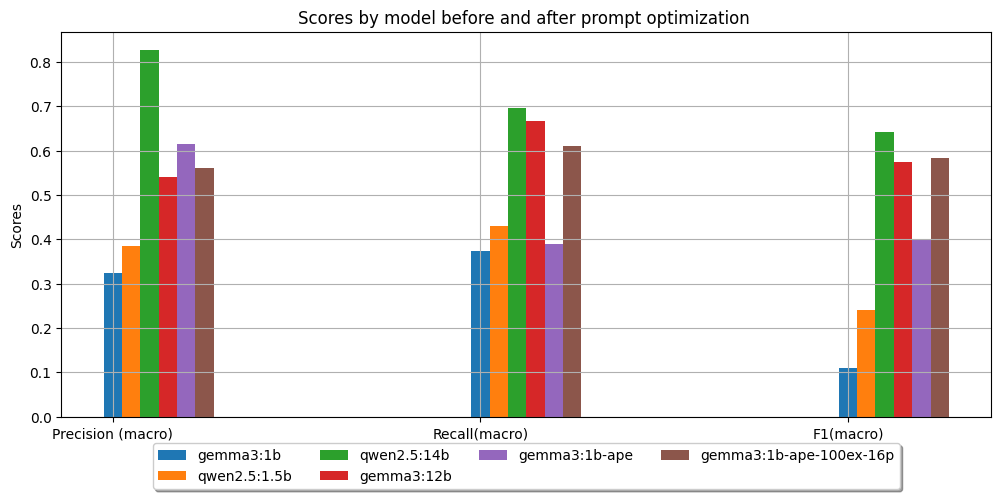

In [50]:
plot_metrics(
    metrics_baseline,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before and after prompt optimization ",
)

### Langfuse evaluation

## Fine-tuning using LoRA method

### Prepare training dataset

In [65]:
from jinja2 import Template

system_content_str = """
    Your input fields are:
    1. `sms_text` (str)

    Your output fields are:
    1. `category` (Literal['ham', 'spam', 'smishing'])

    All interactions will be structured in the following way, with the appropriate values filled in.

    Inputs will have the following structure:

    [[ ## sms_text ## ]]
    {sms_text}

    Outputs will be a JSON object with the following fields.

    {
      "category": "{category}        # note: the value you produce must be one of: ham; spam; smishing"
    }

    In adhering to this structure, your objective is:
            Given an SMS text, predict whether it is ham, spam, or smishing.
            Output only the predicted label.
        """


user_content_str = """
    [ ## sms_text ## ]]
    {{ sms_text }}

    Respond with a JSON object in the following order of fields: `category` (must be formatted as a valid Python Literal['ham', 'spam', 'smishing']).
"""

predict_str = """
```json
{
  "category": {{ predicted_label | tojson }}
}
```
"""


template_chat_str = """
{
  "messages": [
    {
      "role": "system",
      "content": {{ system_prompt | tojson }}
    },
    {
      "role": "user",
      "content": {{ user_prompt | tojson}}
    },
    {
      "role": "assistant",
      "content": {{ predict | tojson }}
    }
  ]
}
"""

template_complete_str = """
{
  "prompt": "Given an SMS text, predict whether it is ham, spam, or smishing.Output only the predicted label: {{ sms_text }}",
  "completion": "{{ predicted_label }}"
}
"""

In [71]:
import json

system_template = Template(system_content_str)
user_template = Template(user_content_str)
predict_template = Template(predict_str)
template_chat = Template(template_chat_str)
dataset = langfuse.get_dataset("sms_phishing_train")
data = []
for item in dataset.items:
    data.append(
        template_chat.render(
            system_prompt=system_template.render(
                sms_text=item.input, category=item.expected_output
            ),
            user_prompt=user_template.render(sms_text=item.input),
            predict=predict_template.render(predicted_label=item.expected_output),
        )
    )

with open(f"{os.environ['EXERCISE_DIR']}/data/train/train.jsonl", "w") as f:
    for record in data:
        try:
            parsed = json.loads(record)
            json_record = json.dumps(parsed)
            f.write(json_record + "\n")
        except json.JSONDecodeError as e:
            pass

In [70]:
dataset = langfuse.get_dataset("sms_phishing_val")
data = []
for item in dataset.items:
    data.append(
        template_chat.render(
            system_prompt=system_template.render(
                sms_text=item.input, category=item.expected_output
            ),
            user_prompt=user_template.render(sms_text=item.input),
            predict=predict_template.render(predicted_label=item.expected_output),
        )
    )

with open(f"{os.environ['EXERCISE_DIR']}/data/train/valid.jsonl", "w") as f:
    for record in data:
        try:
            parsed = json.loads(record)
            json_record = json.dumps(parsed)
            f.write(json_record + "\n")
        except json.JSONDecodeError as e:
            pass

In [ ]:
! ollama pull getindata/gemma3:1b-it-llmops-q4_K_M"

In [60]:
model = "getindata/gemma3:1b-it-llmops-q4_K_M"

In [58]:
ft_run_id = uuid.uuid1()
models = [model]
sms_classifier = SMSClassifier()
run_evaluation(models, sms_classifier, test_ds, classes, ft_run_id, prefix="fine-tune")

Average Metric: 93.00 / 100 (93.0%): 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


In [59]:
metrics_ft = get_all_metric(models, ft_run_id, classes, prefix="fine-tune")
metrics_ft

{'getindata/gemma3:1b-it-llmops-q4_K_M': {'precision': 0.8771929824561404,
  'recall': 0.721285140562249,
  'f1': 0.6963739912483233}}

In [61]:
metrics_baseline["gemma3:1b-ft"] = metrics_ft[model]

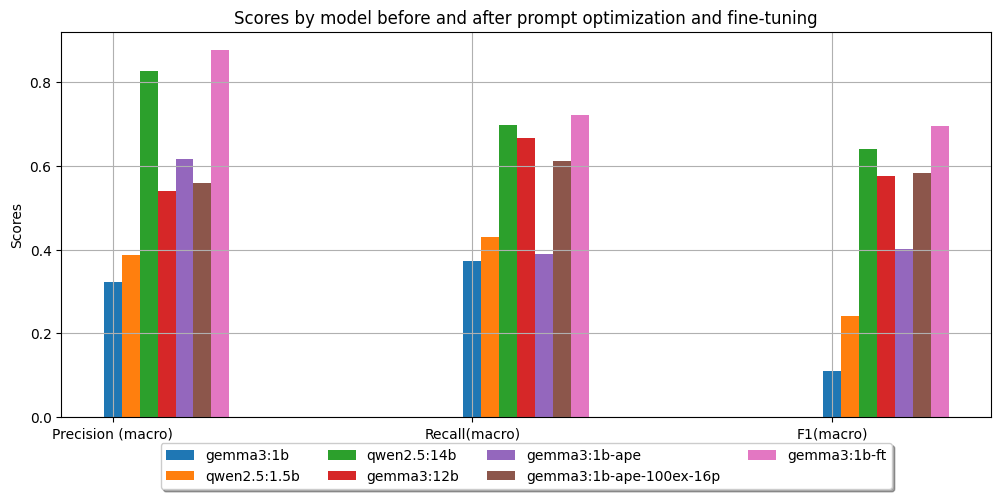

In [63]:
plot_metrics(
    metrics_baseline,
    ["Precision (macro)", "Recall(macro)", "F1(macro)"],
    "Scores by model before and after prompt optimization and fine-tuning",
)